In [1]:
import h5py
import numpy as np

from e2c_train import create_e2c

from keras import backend as K
from keras.layers import Input
from keras.models import Model

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.set_cmap('jet')

In [3]:
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP/'
data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP_RATE/'

output_dir = '/data3/Astro/lstm_rom/e2c_larry/saved_models/' # load model data

case_name = '9w_bhp_rate'

# suffix = '_single_out_rel_2'
# suffix = '_fix_wl_rel_1'
target_suffix = '_fix_wl_rel_2' # the dataset being evaluated here
# model_suffix = '_single_out_rel_3' # the dataset used to train the model
case_suffix = '_fix_wl_rel_2'
train_suffix = '_with_p'
model_suffix = '_flux_loss'

num_eval, num_t, run_eval = 2000,20,100

eval_file = case_name + '_e2c_eval' + target_suffix + train_suffix + '_n%d_dt20day_nt%d_nrun%d.mat'%(num_eval, num_t, run_eval)

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + target_suffix + '.mat'
ctrl_data = ctrl_file + target_suffix + '.mat'

## Load E2C model

In [4]:
latent_dim, u_dim = 50, 9
input_shape = (60, 60, 2) # change from _with_p to _no_p
encoder, decoder, transition = create_e2c(latent_dim, u_dim, input_shape)

num_train, latent_dim, learning_rate, epoch = 6000, 50, 1e-4, 10

In [5]:
encoder.load_weights(output_dir + 'e2c_encoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
decoder.load_weights(output_dir + 'e2c_decoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
transition.load_weights(output_dir + 'e2c_transition_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))

## One step prediction

In [6]:
hf_r = h5py.File(data_dir + eval_file, 'r')
state_t_eval = np.array(hf_r.get('state_t'))
state_t1_eval = np.array(hf_r.get('state_t1'))
# print(list(hf_r.keys()))
# state_t_eval = np.array(hf_r.get('sat_t'))
# state_t1_eval = np.array(hf_r.get('sat_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
num_eval = state_t_eval.shape[0]
# dt_eval = np.ones((num_eval,1))
dt_eval = np.array(hf_r.get('dt'))
hf_r.close()

In [7]:
print(state_t_eval.shape)

(2000, 60, 60, 2)


In [8]:
num_eval = 20 # pick 20 out of 2200 evals
state_t_eval = state_t_eval[:num_eval, ...]
state_t1_eval = state_t1_eval[:num_eval, ...]
bhp_eval = bhp_eval[:num_eval, ...]
dt_eval = dt_eval[:num_eval,...]

In [9]:
print(state_t_eval.shape)
print(state_t1_eval.shape)
print(bhp_eval[:,:5].min().min())
print(bhp_eval[:,:5].max().max())

print(state_t_eval.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)
0.00037096116005723353
0.16362758931517363
(20, 60, 60, 2)


In [10]:
xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))
dt = Input(shape=(1,))

In [11]:
zt = encoder(xt)
xt_rec = decoder(zt)

zt1_pred = transition([zt, ut, dt])
xt1_pred = decoder(zt1_pred)

e2c_model = Model([xt, ut, dt], [xt_rec, xt1_pred])

In [11]:
# print(zt_mean)
# a = K.eval(zt_mean)

In [12]:
[state_t_rec, state_t1_pred] = e2c_model.predict([state_t_eval, bhp_eval, dt_eval])

In [13]:
print(state_t_rec.shape)
print(state_t1_pred.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)


In [14]:
print(state_t_eval[:,:,:,0].max())
print(state_t_eval[:,:,:,0].min())

print(state_t_eval[:,:,:,1].max())
print(state_t_eval[:,:,:,1].min())

0.6751619047037983
0.1
0.5188942930678313
0.04810388626899816


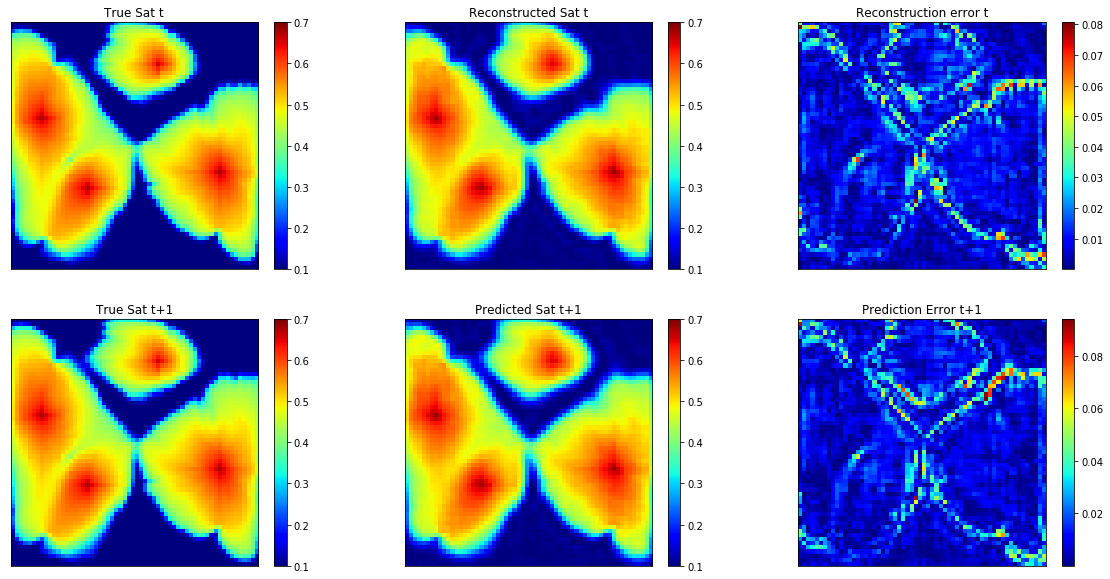

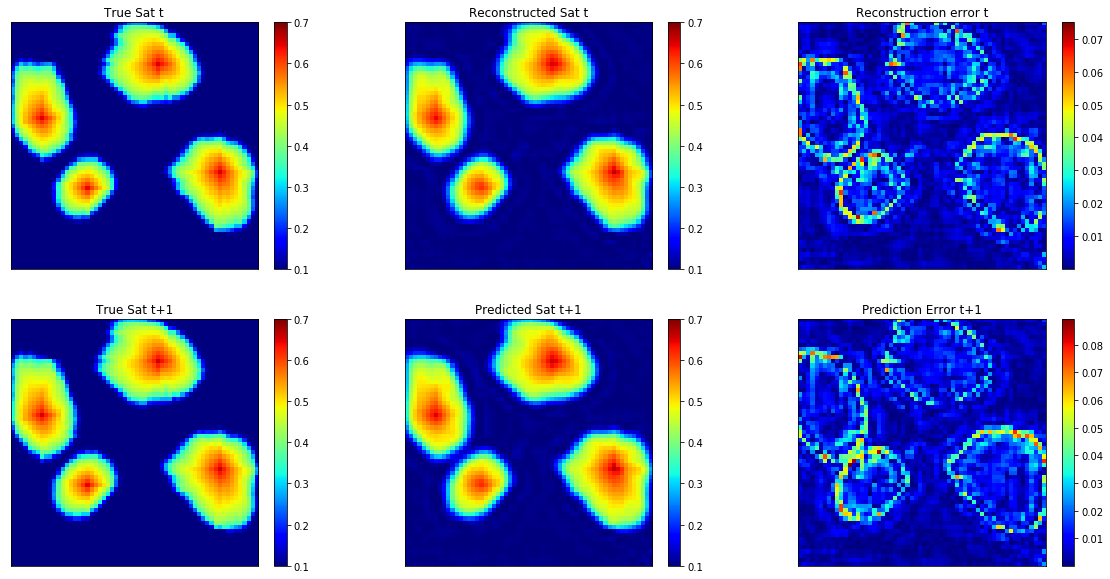

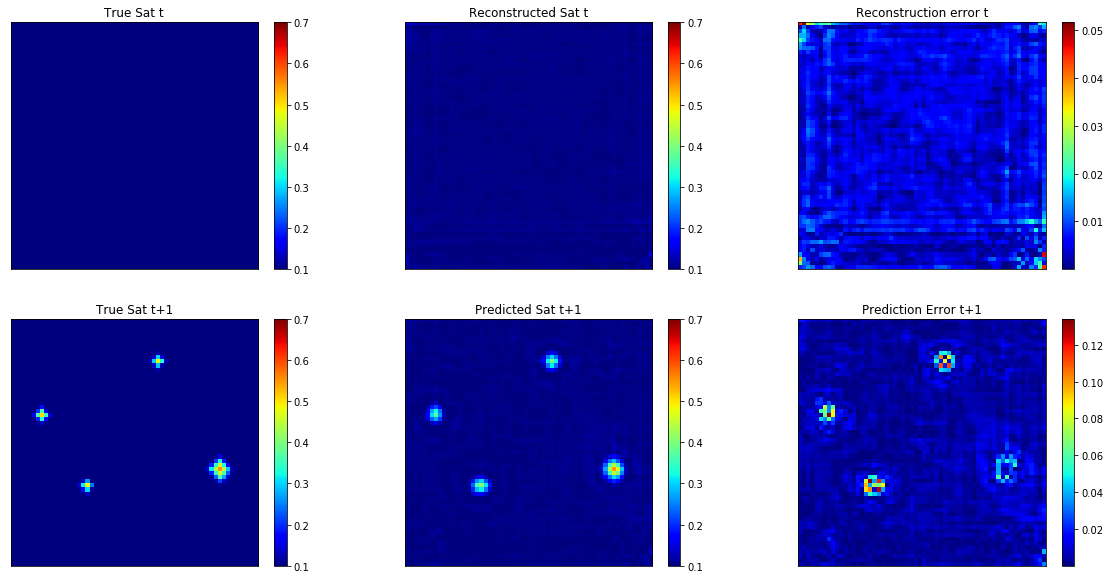

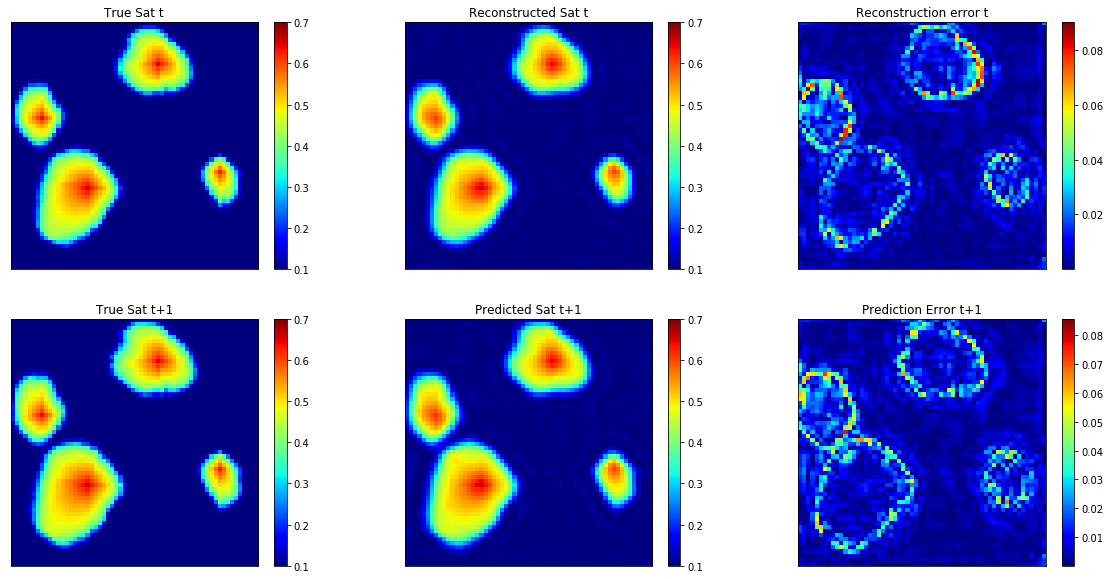

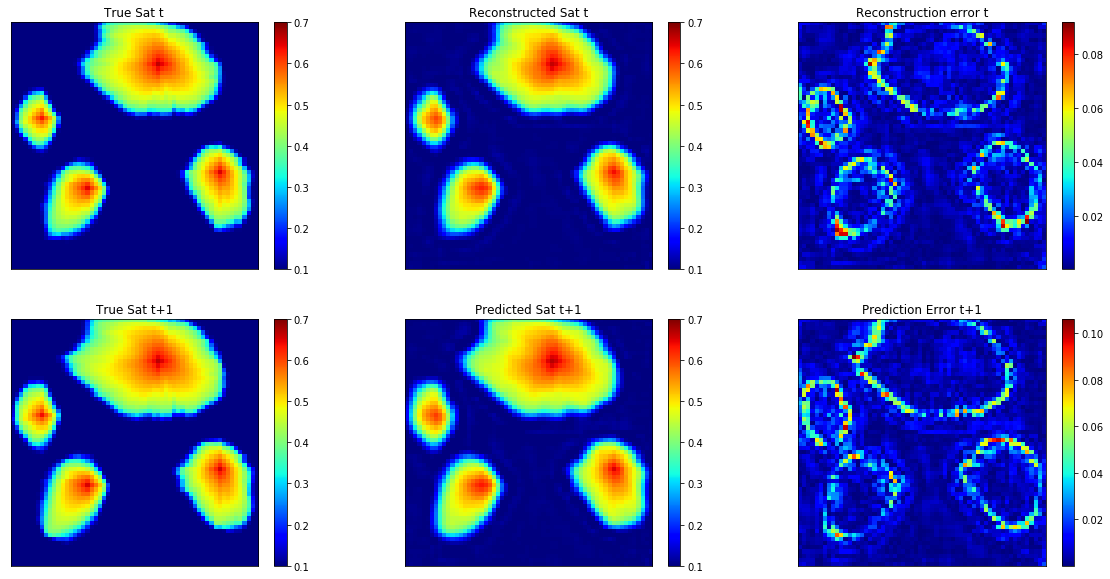

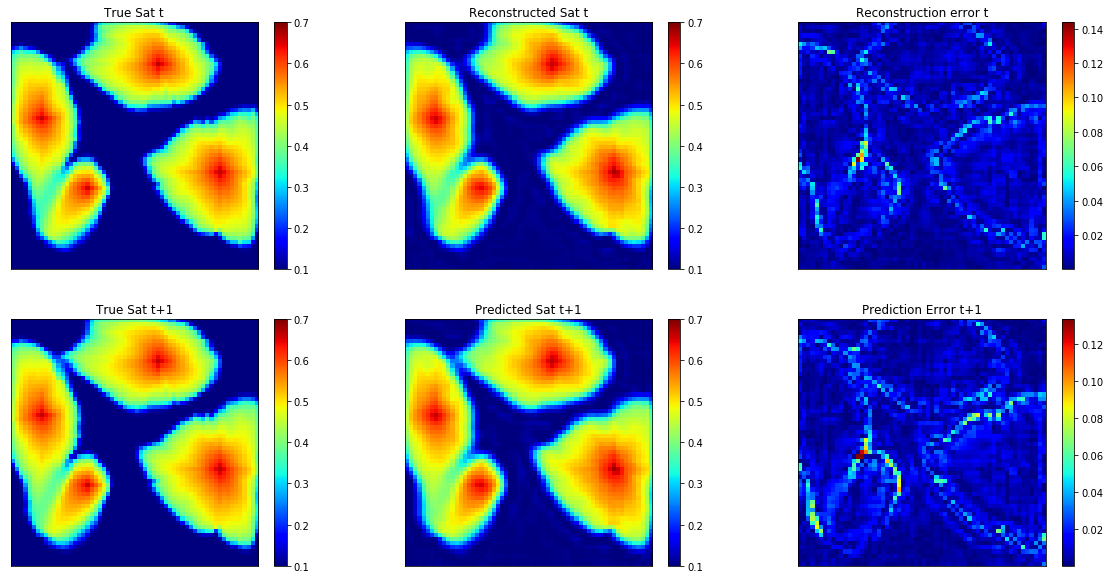

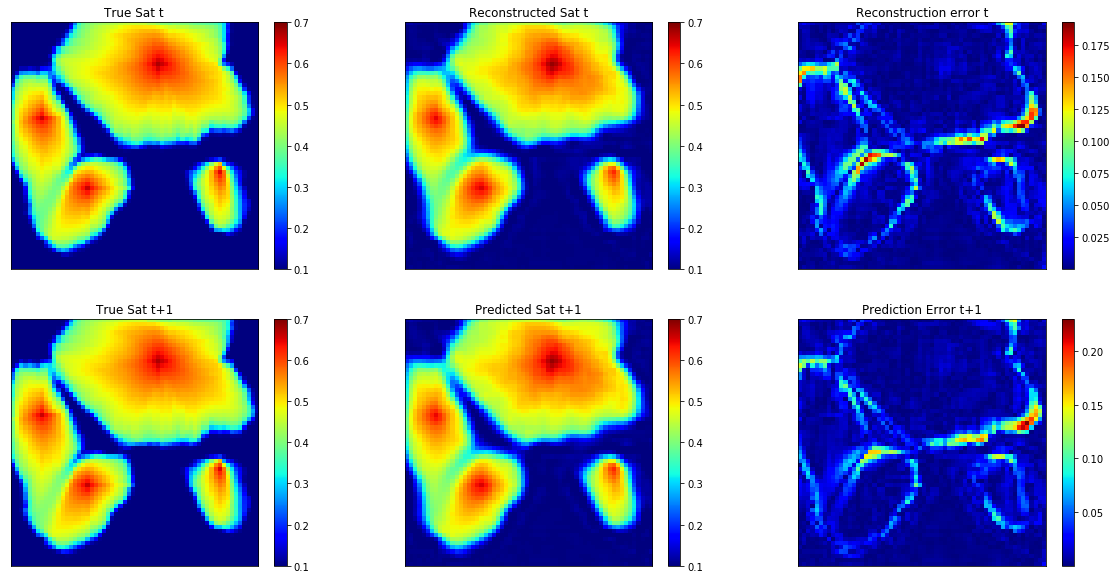

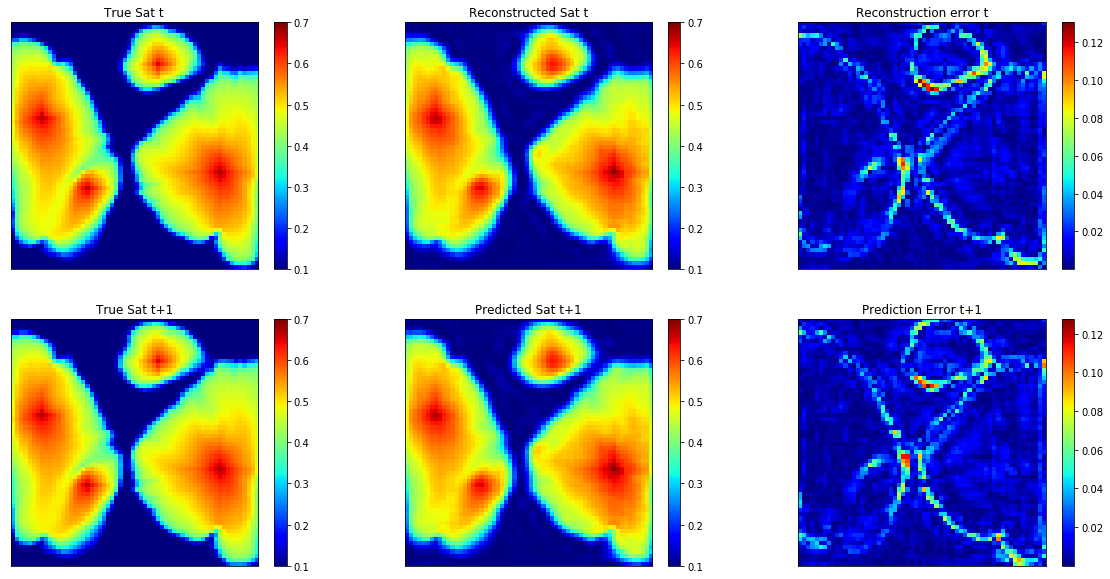

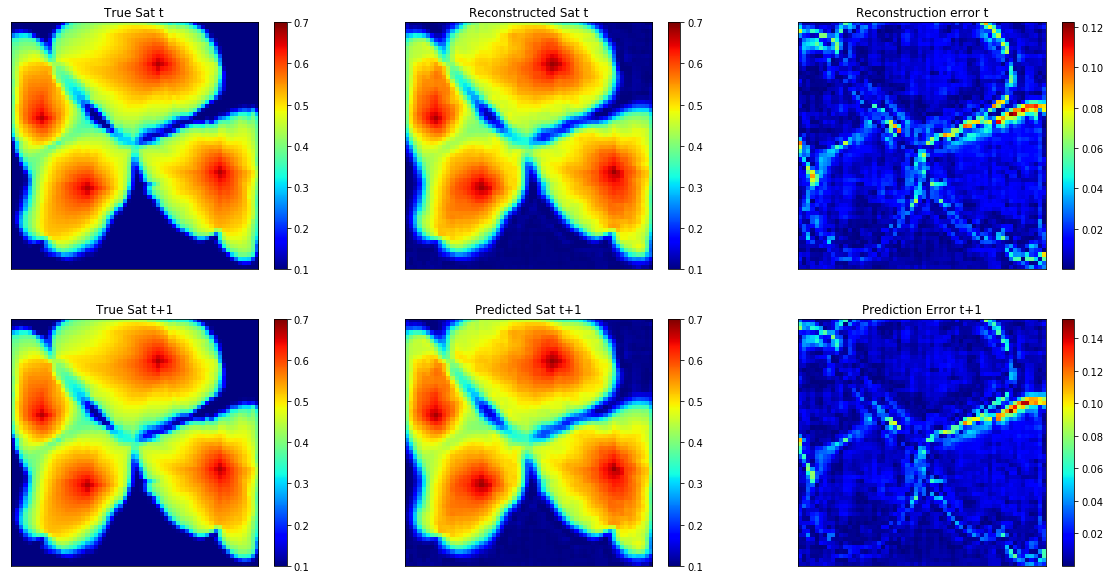

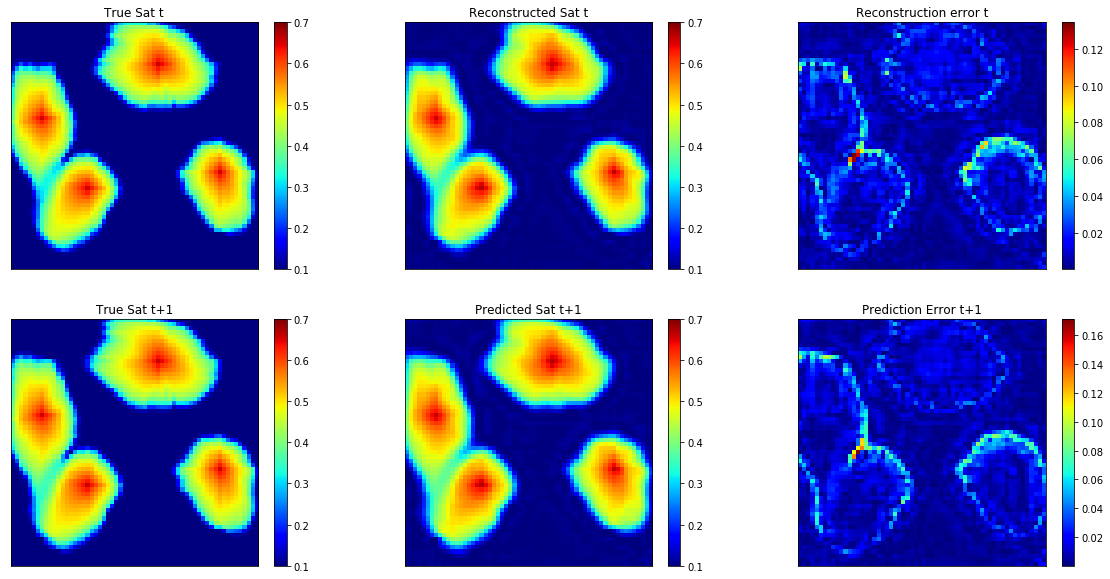

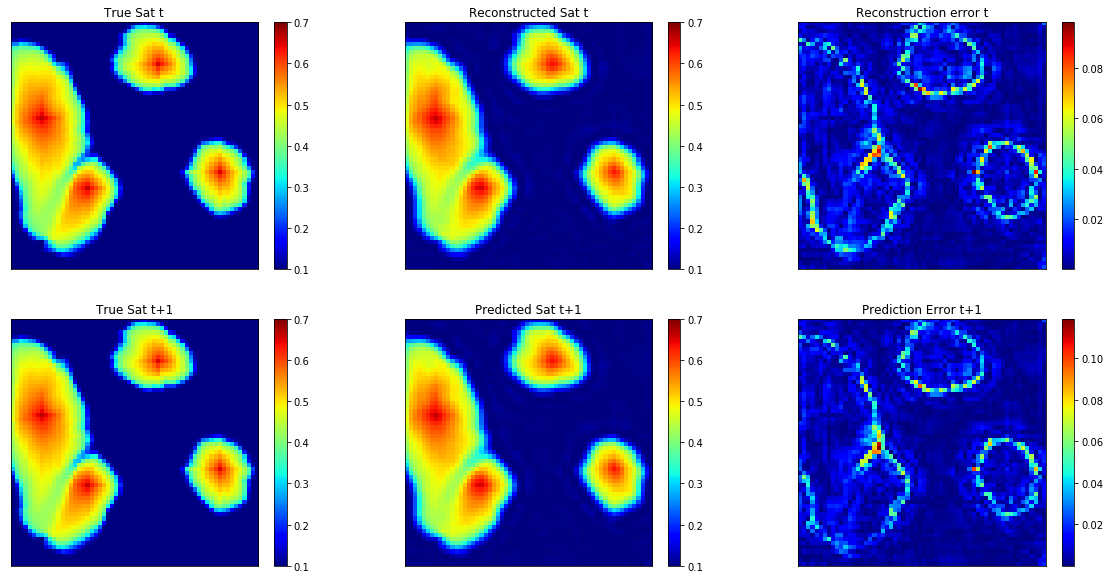

In [15]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec[k, :, :, 0] - state_t_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred[k, :, :, 0] - state_t1_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

In [16]:
sat_threshold = 0.105

sat_bin = np.where(state_t_eval[:,:,:,0]> sat_threshold, 1, 0)
sat_t1_bin = np.where(state_t1_eval[:,:,:,0]> sat_threshold, 1, 0)

sat_rec_bin = np.where(state_t_rec[:,:,:,0]> sat_threshold, 1, 0)
sat_pred_bin = np.where(state_t1_pred[:,:,:,0]> sat_threshold, 1, 0)

In [17]:
print(sat_bin.shape)

(20, 60, 60)


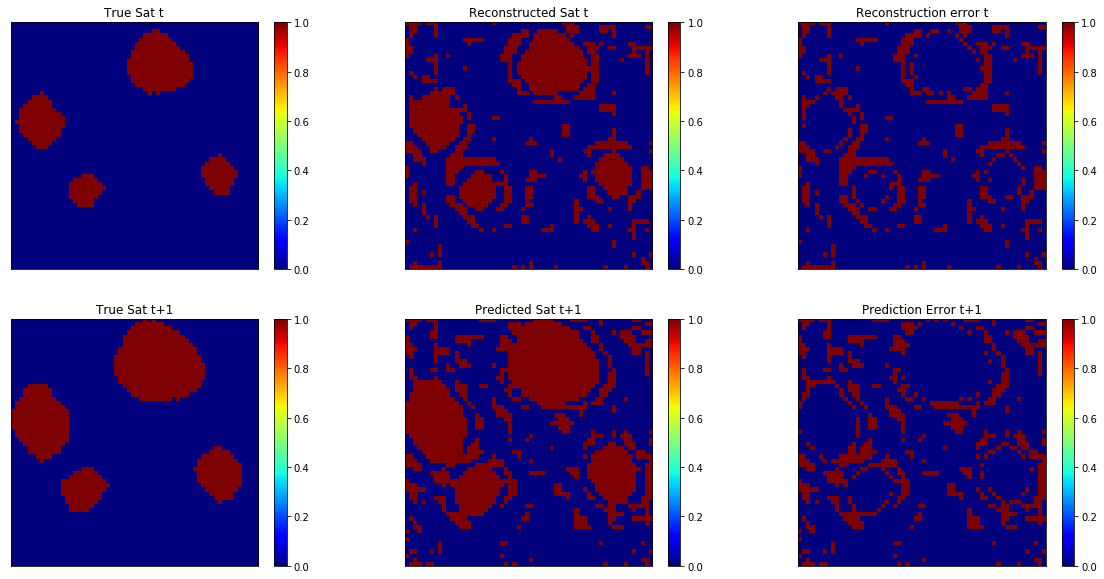

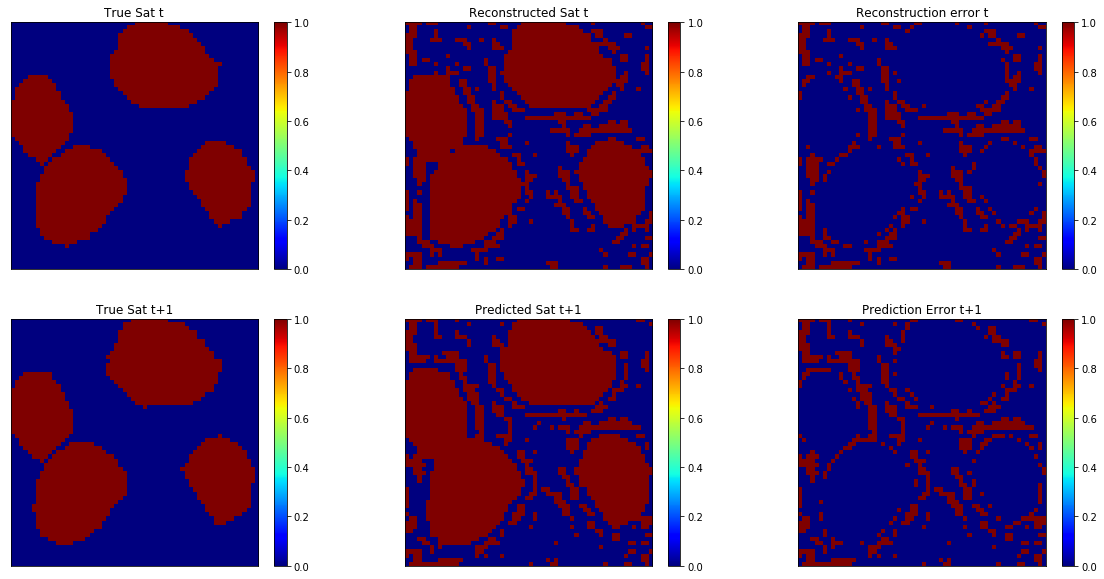

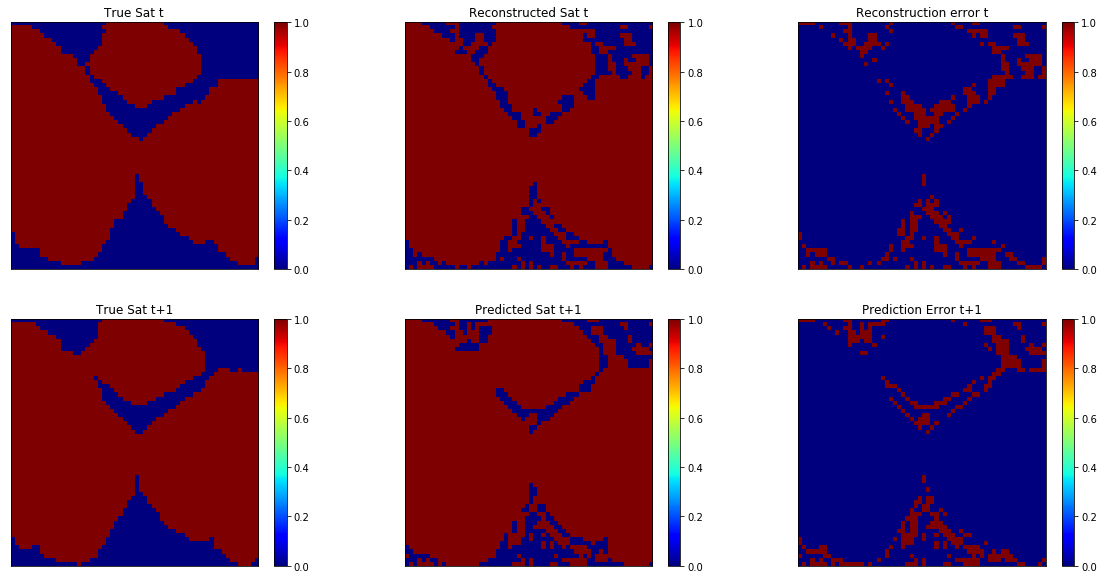

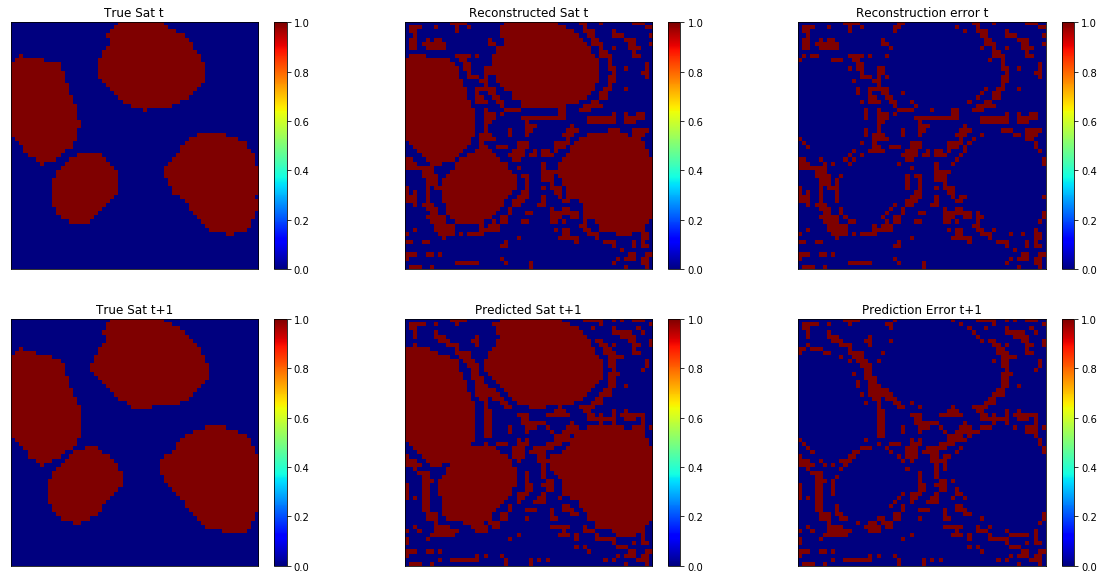

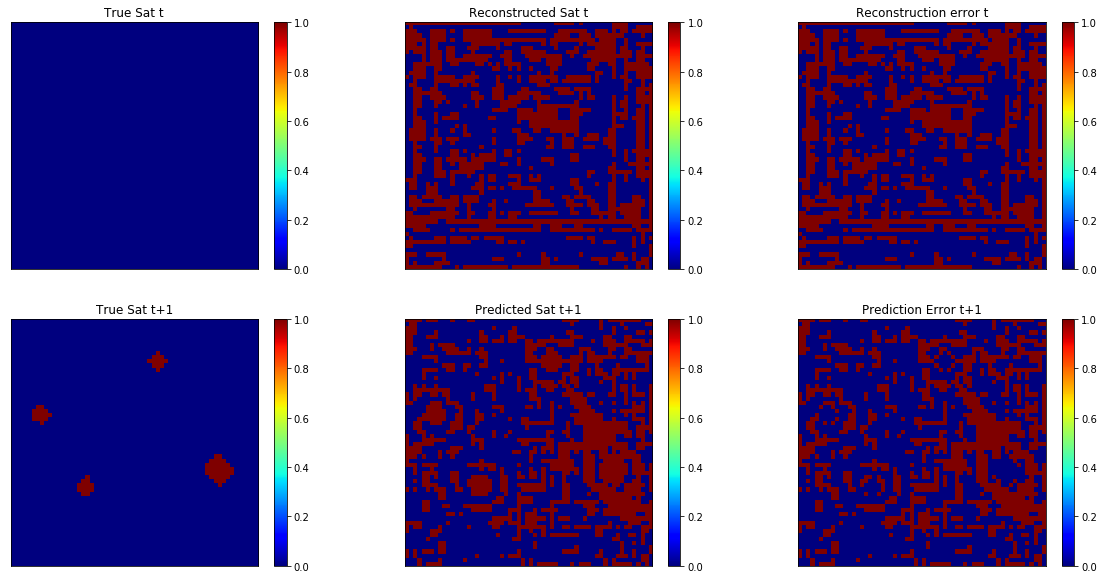

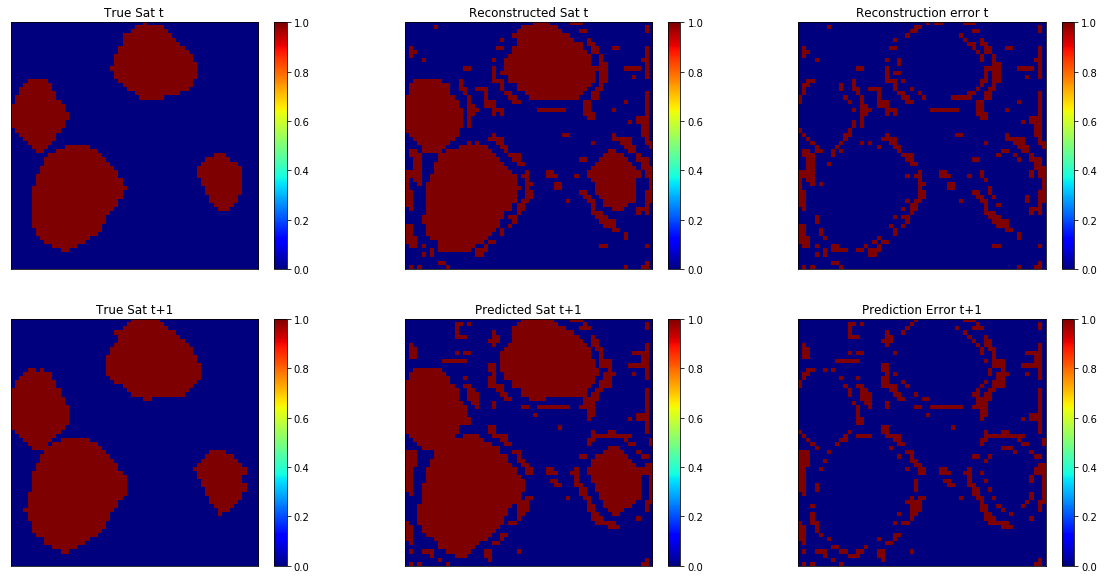

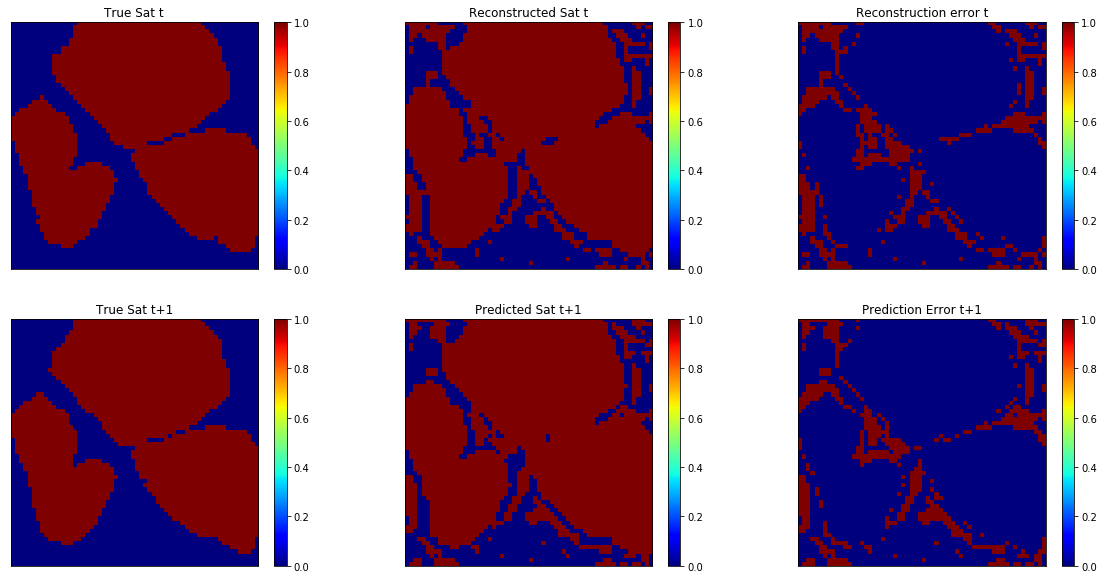

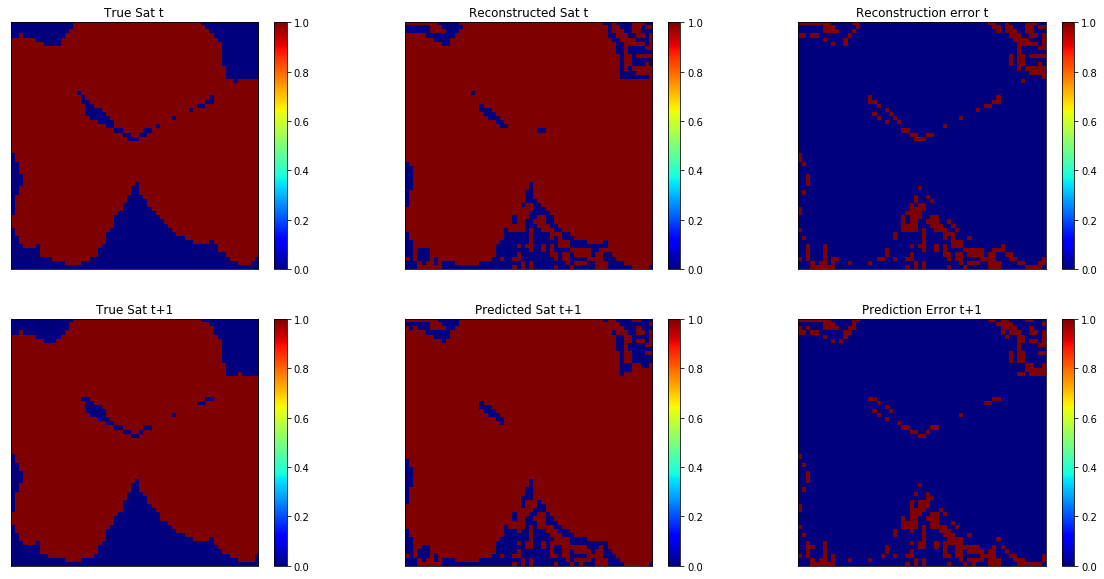

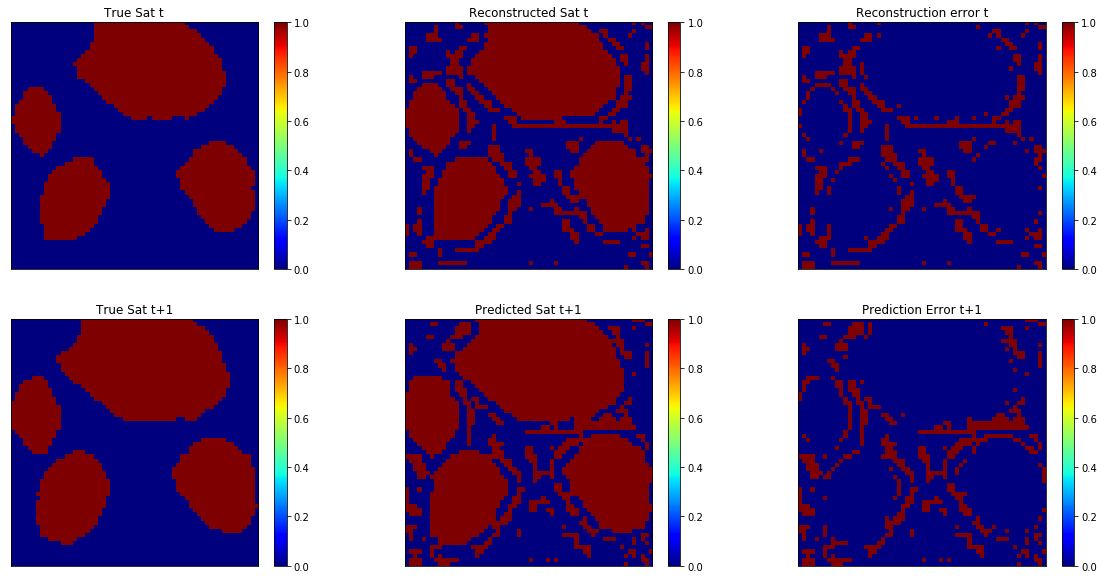

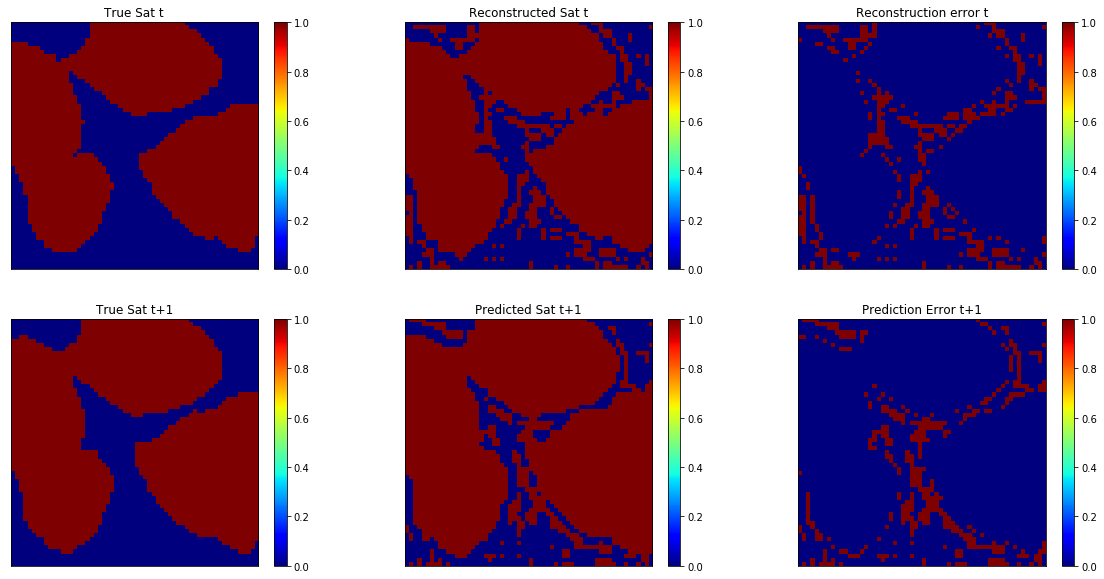

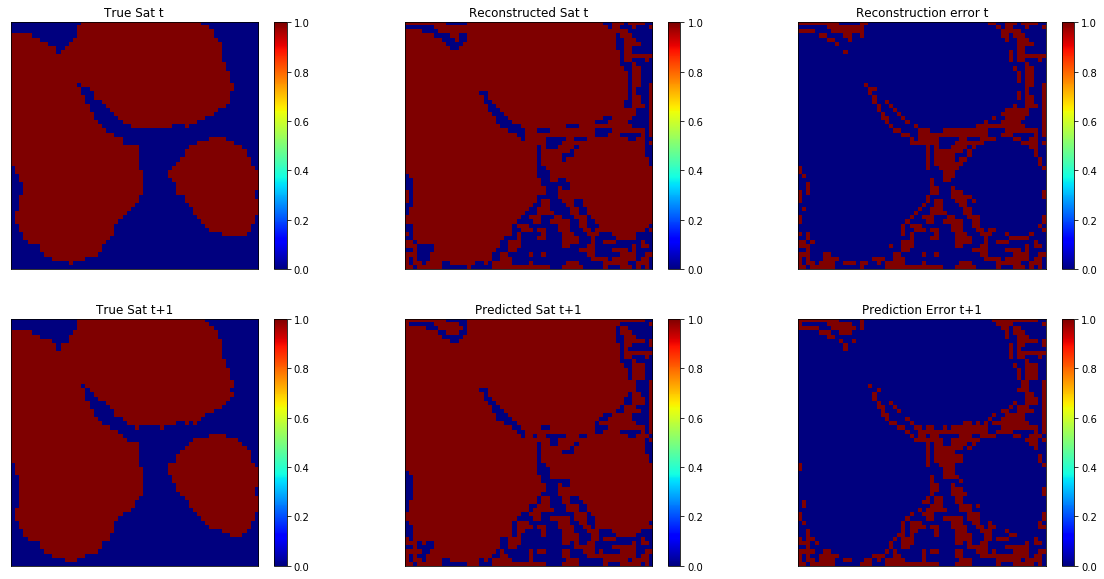

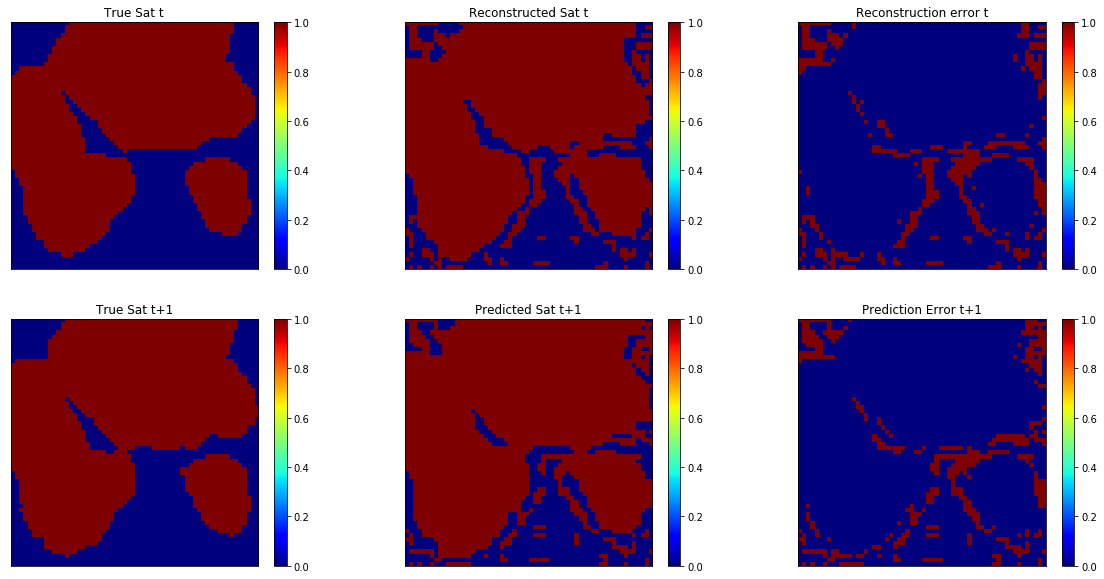

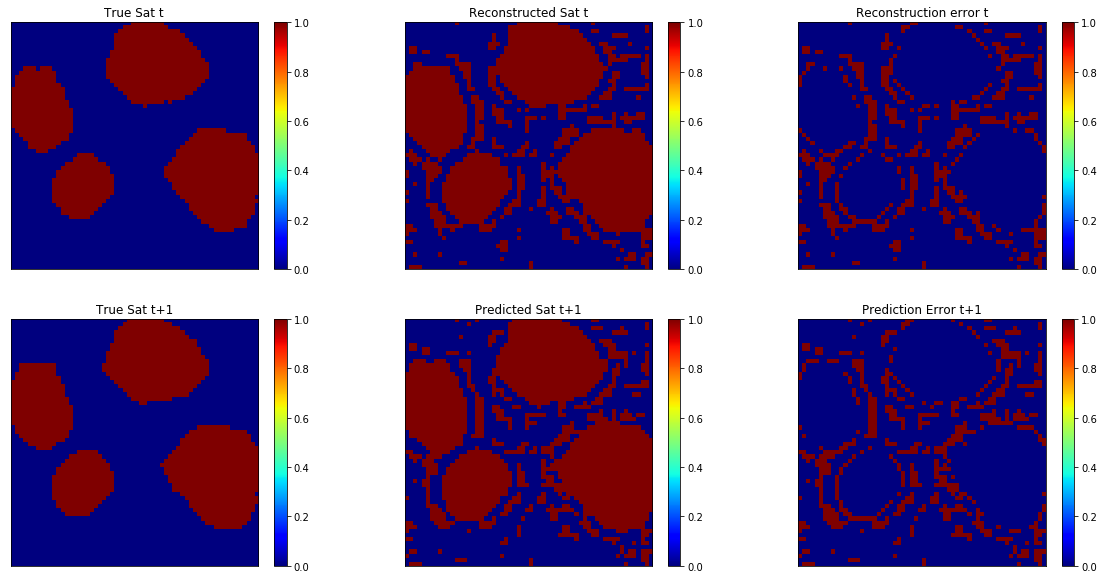

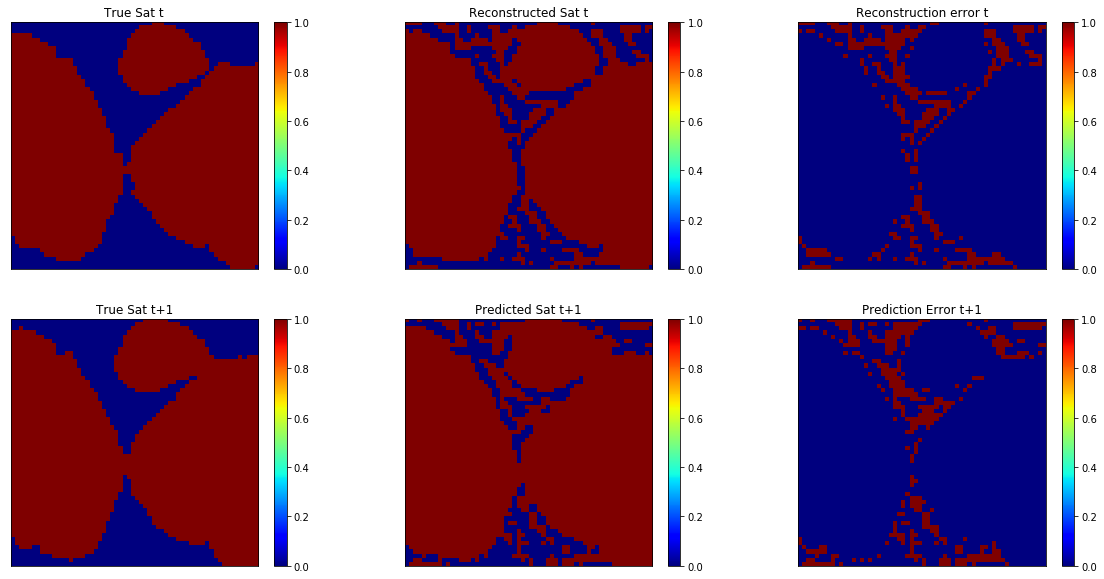

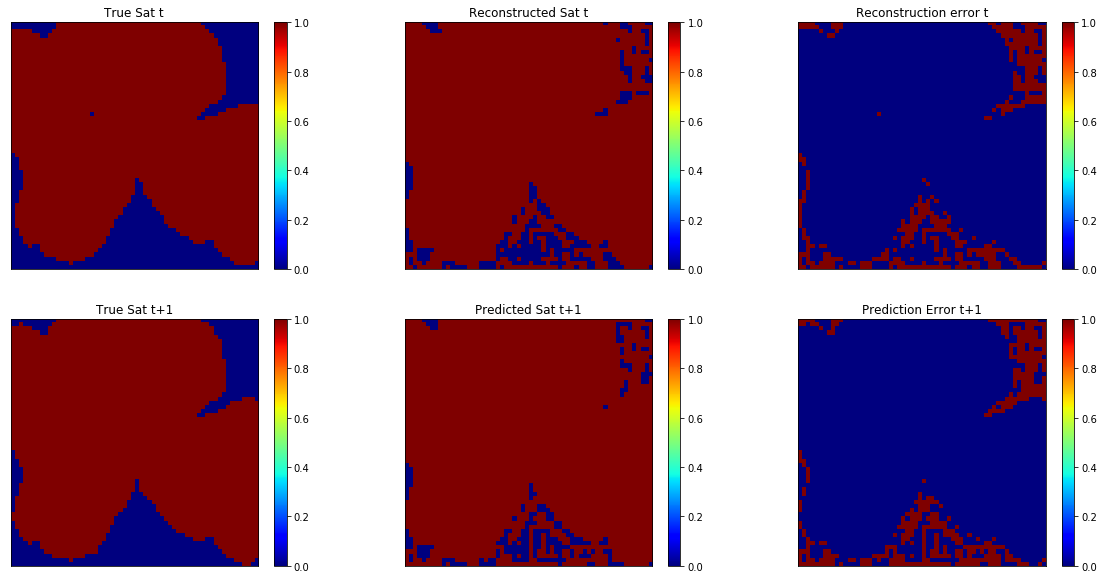

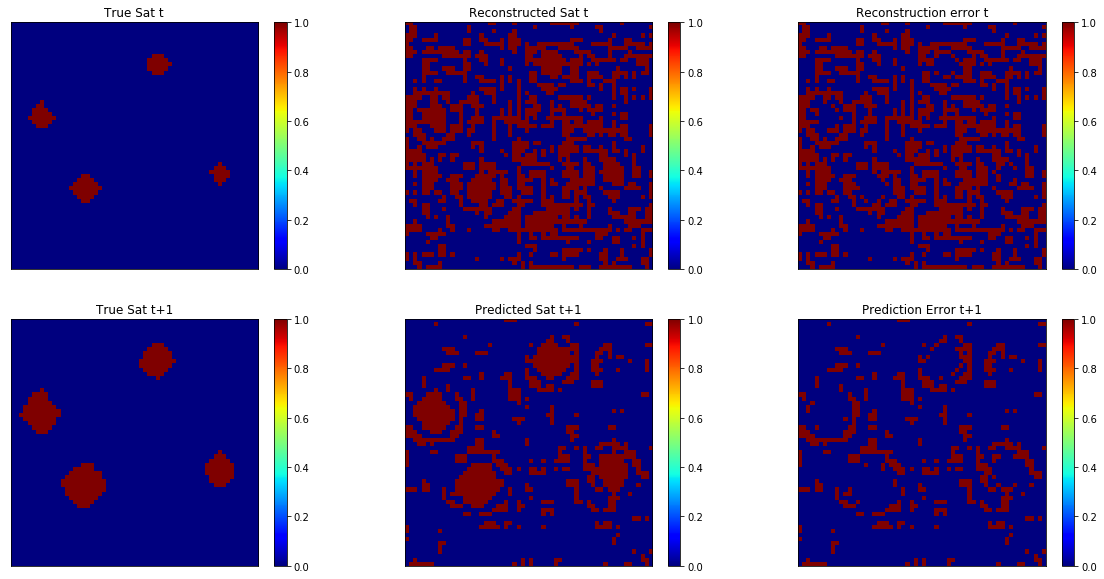

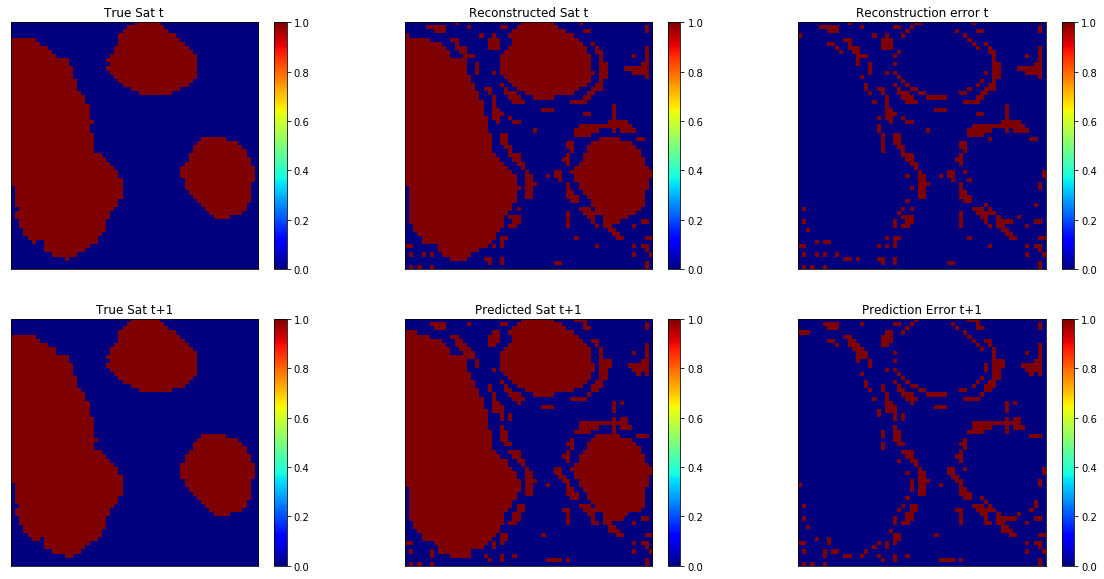

In [18]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(sat_bin[k, :, :])
    plt.clim([0, 1])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(sat_rec_bin[k, :, :])
    plt.clim([0, 1])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(sat_bin[k, :, :] - sat_rec_bin[k, :, :]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(sat_t1_bin[k, :, :])
    plt.clim([0, 1])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(sat_pred_bin[k, :, :])
    plt.clim([0, 1])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(sat_pred_bin[k, :, :] - sat_t1_bin[k, :, :]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

In [19]:
p_max = 370*14.5038
p_min = 280*14.5038
p_diff = p_max - p_min

state_t_eval_plot = state_t_eval * p_diff + p_min
state_t_rec_plot = state_t_rec * p_diff + p_min
state_t1_eval_plot = state_t1_eval * p_diff + p_min
state_t1_pred_plot = state_t1_pred * p_diff + p_min

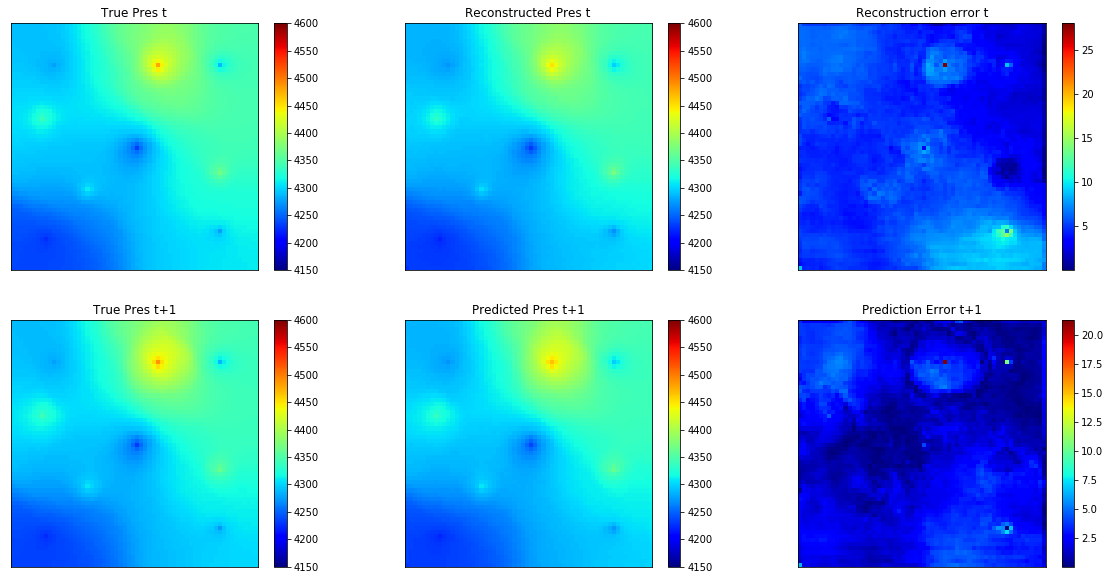

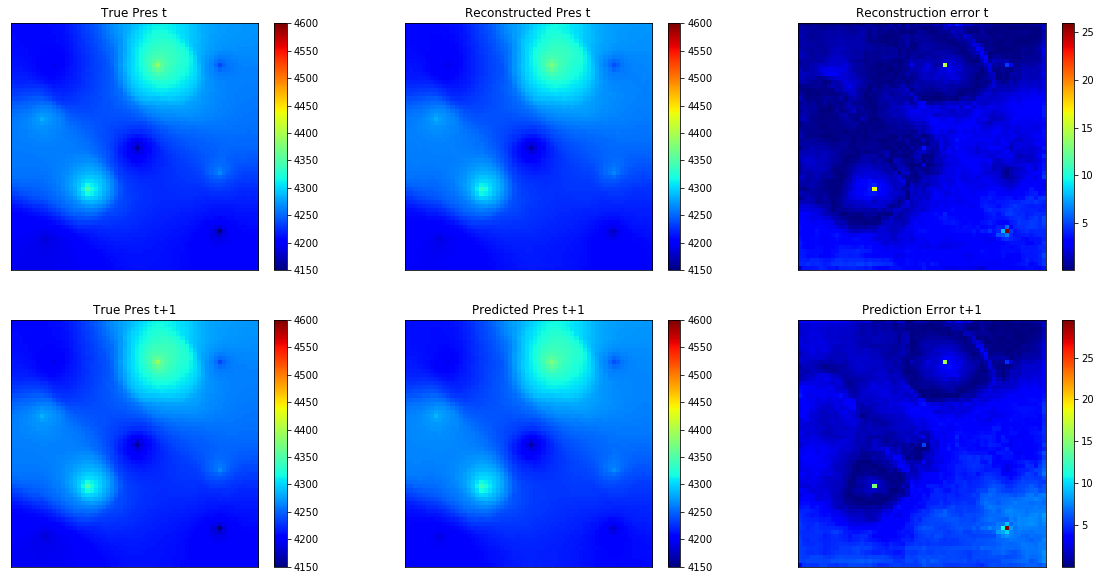

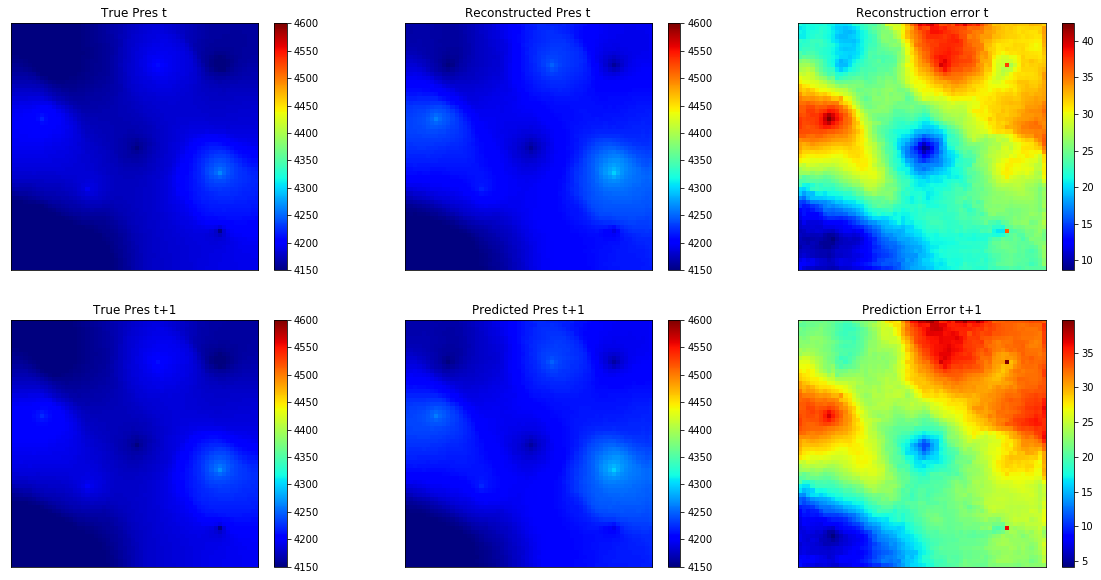

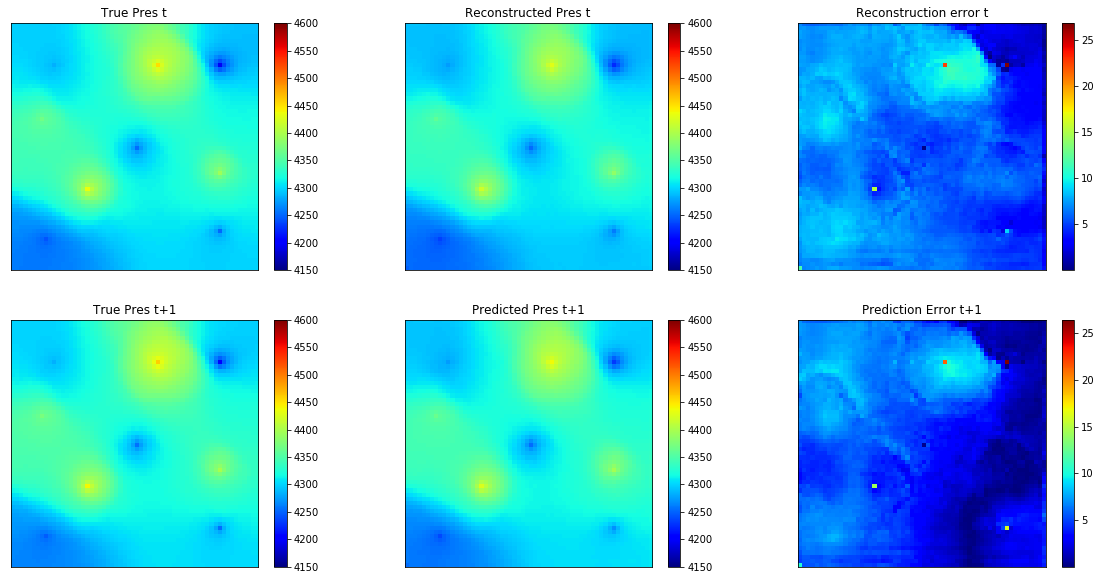

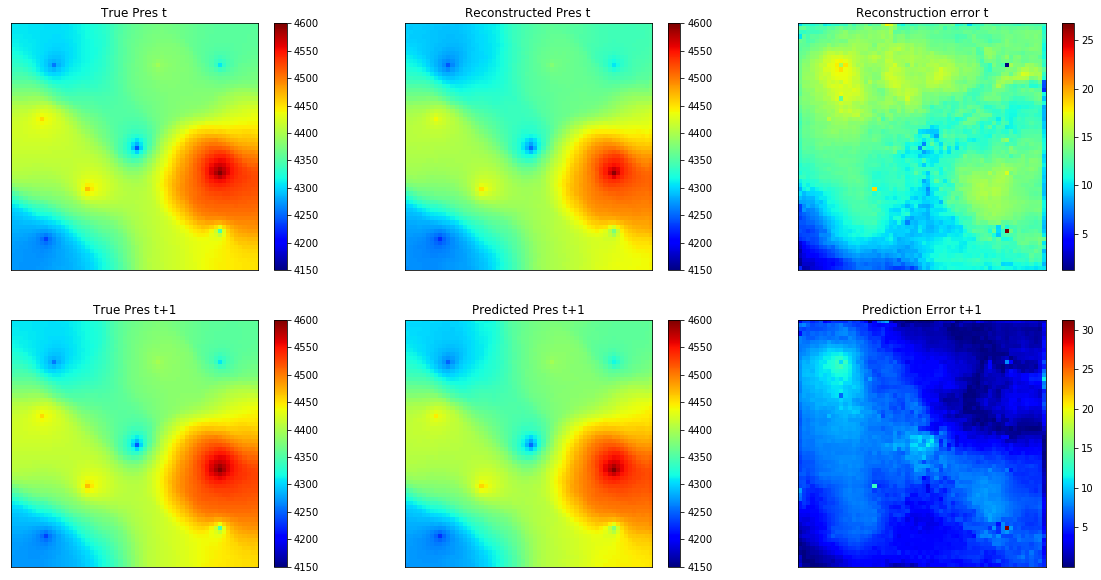

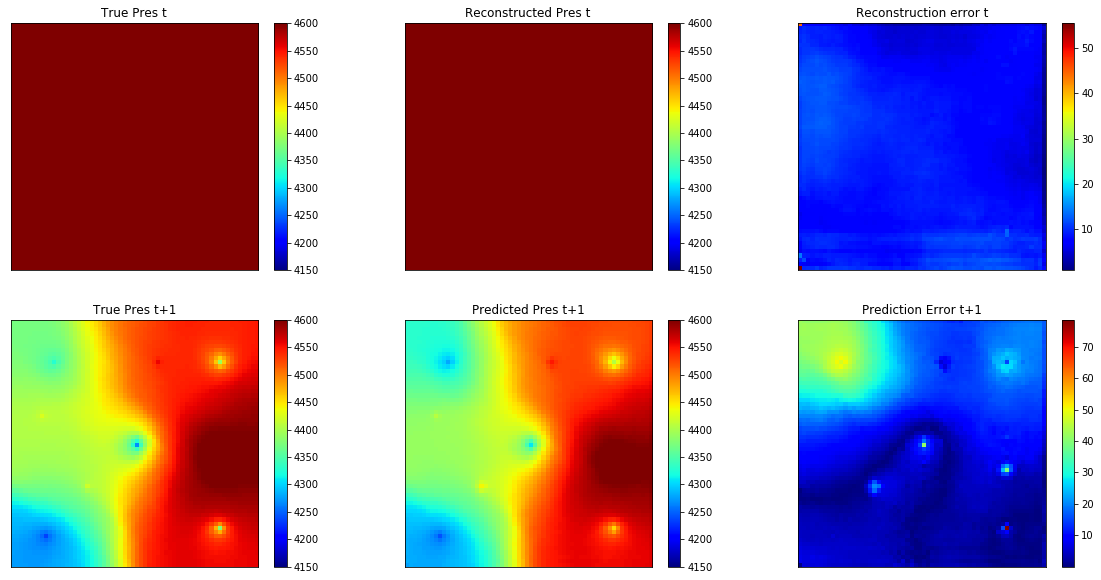

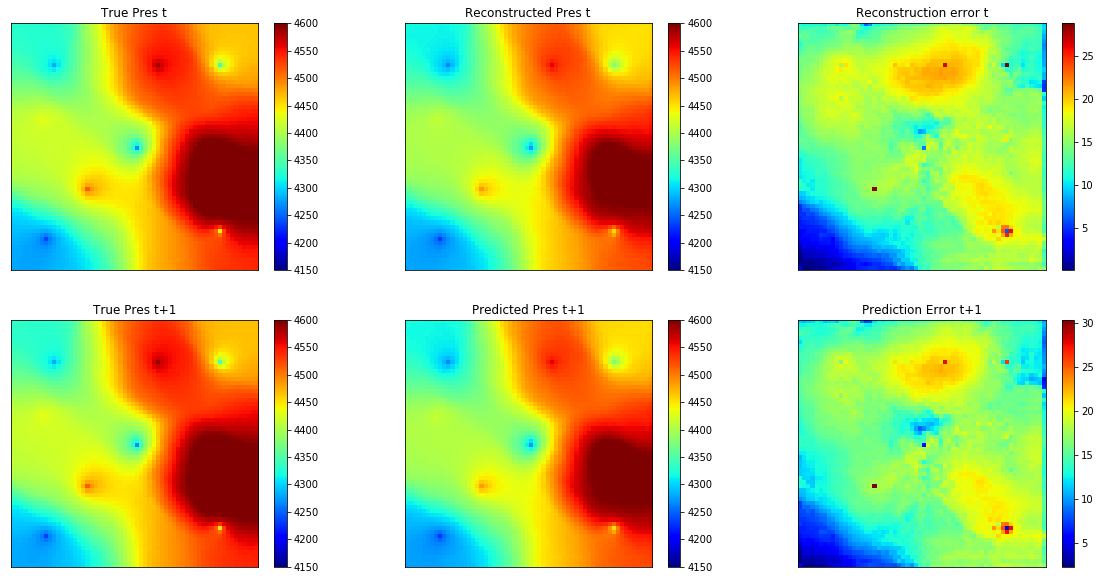

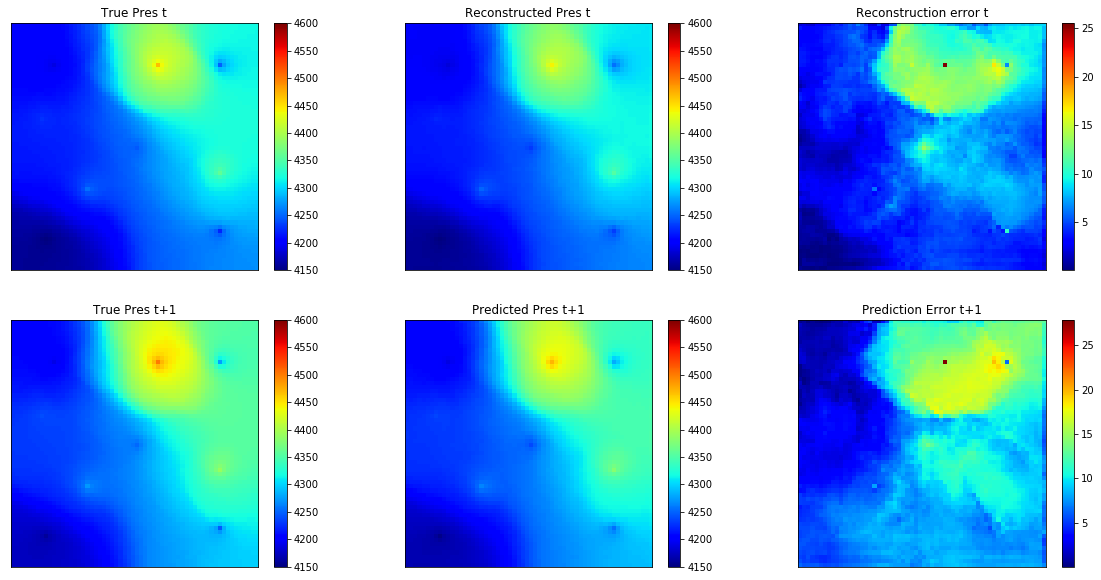

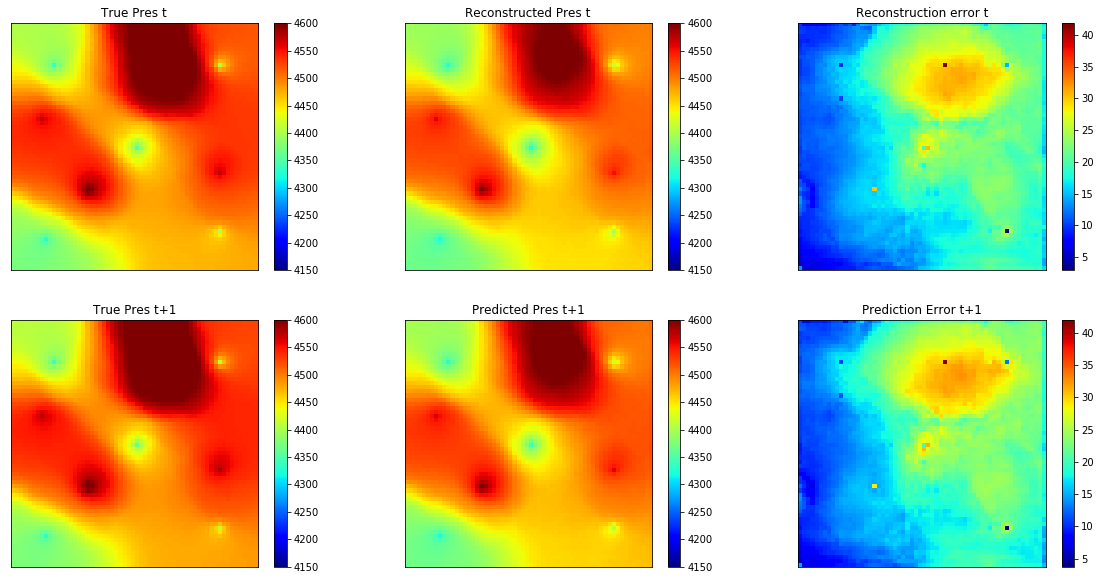

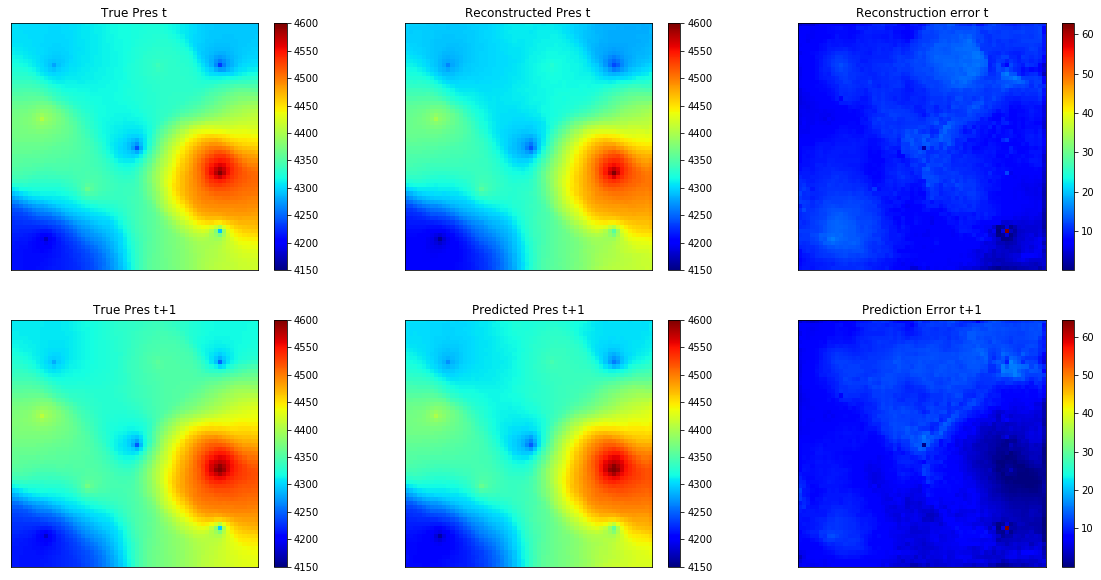

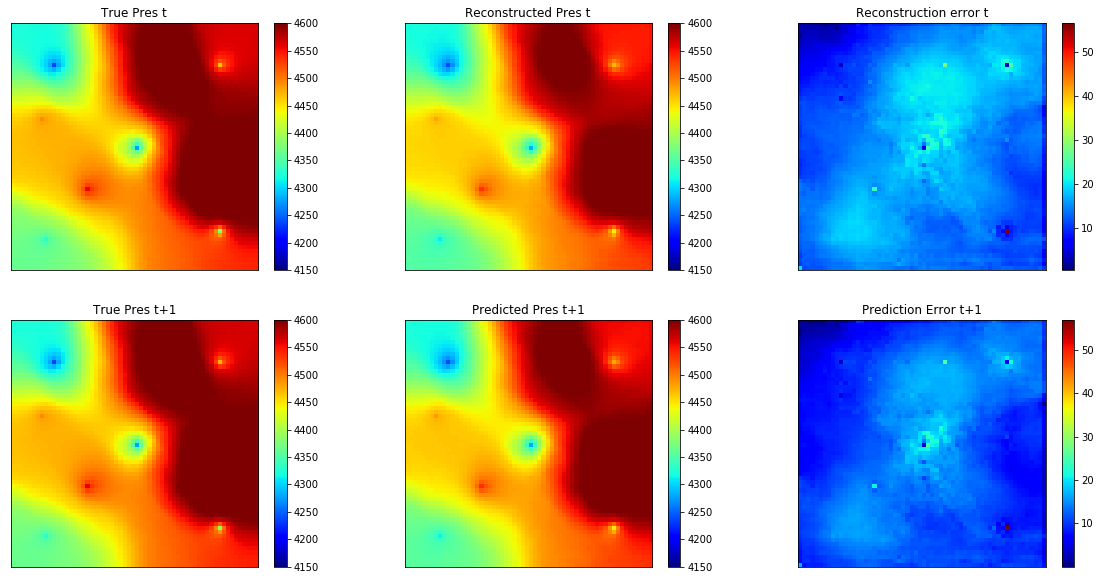

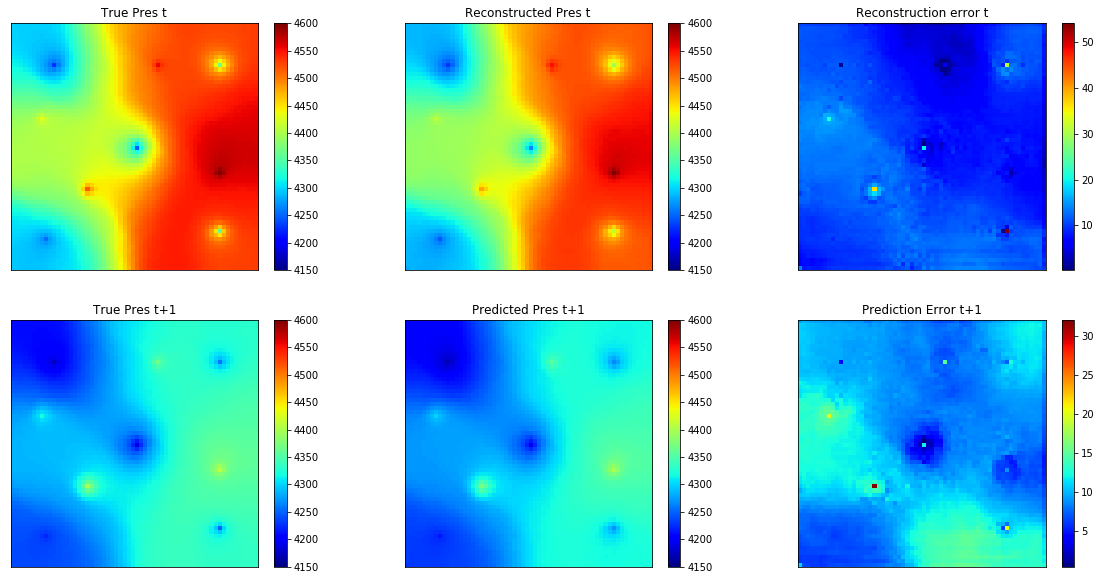

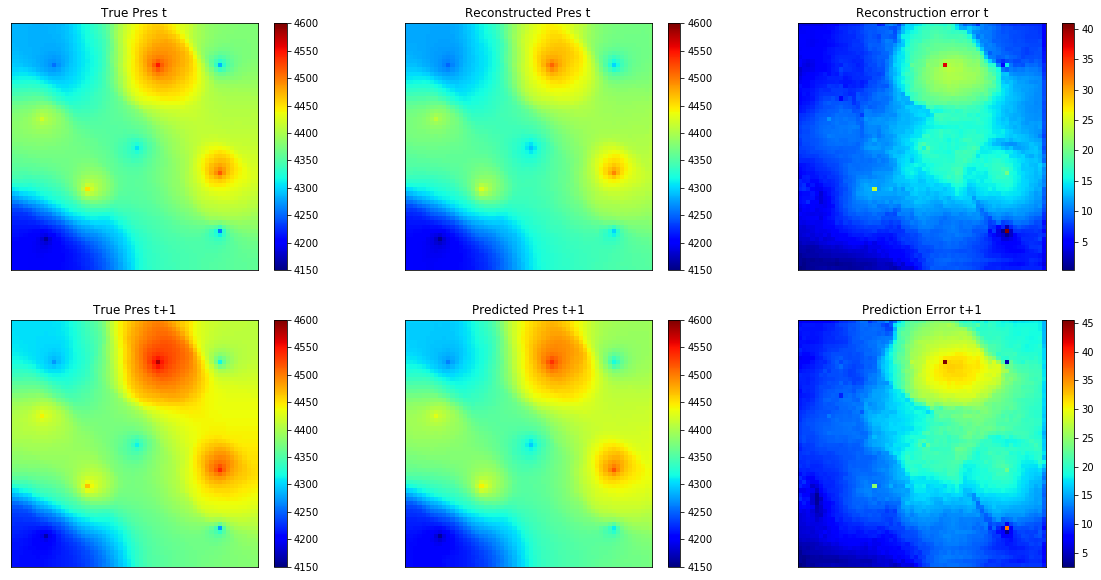

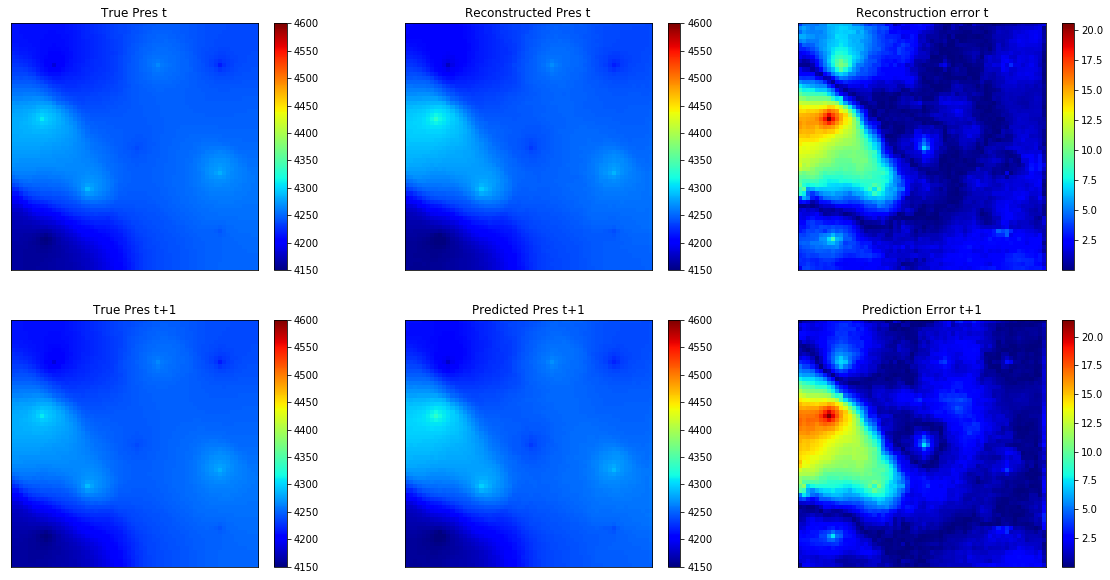

In [20]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Pres t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 1] - state_t_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Pres t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 1] - state_t1_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

## Sequential prediction

In [21]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [22]:
print(sat.shape)

(3600, 40400)


In [23]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()
# bhp -= 0.45

In [24]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 9)


In [25]:
sat = sat.T.reshape((400, 101, 3600))
pres = pres.T.reshape((400, 101, 3600))

In [26]:
ind_case = [1, 101, 201, 301]

In [27]:
t00 = np.array([1,3,7,15,25])

indt = np.concatenate(([0],t00,t00+25,t00+50,t00[:-1]+75),axis=0)
indt1 = np.concatenate((t00,t00+25,t00+50,t00+75),axis=0)
indt_del = indt1 - indt
indt_del = indt_del / max(indt_del)
print(indt)
print(indt1)
print(indt_del.shape)
print(indt_del)

[ 0  1  3  7 15 25 26 28 32 40 50 51 53 57 65 75 76 78 82 90]
[  1   3   7  15  25  26  28  32  40  50  51  53  57  65  75  76  78  82
  90 100]
(20,)
[0.1 0.2 0.4 0.8 1.  0.1 0.2 0.4 0.8 1.  0.1 0.2 0.4 0.8 1.  0.1 0.2 0.4
 0.8 1. ]


In [28]:
num_case = 4
num_tstep = indt_del.shape[0]
sat_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
pres_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
print(sat_pred.shape)

(4, 20, 60, 60, 1)


In [29]:
bhp_seq = bhp[ind_case, :]

In [30]:
sat_t_seq = sat[ind_case, 0, :].reshape((num_case, 60, 60, 1)) # 4 here is the 4th timestep, t = 8, change to 0 now
pres_t_seq = pres[ind_case, 0, :].reshape((num_case, 60, 60, 1))

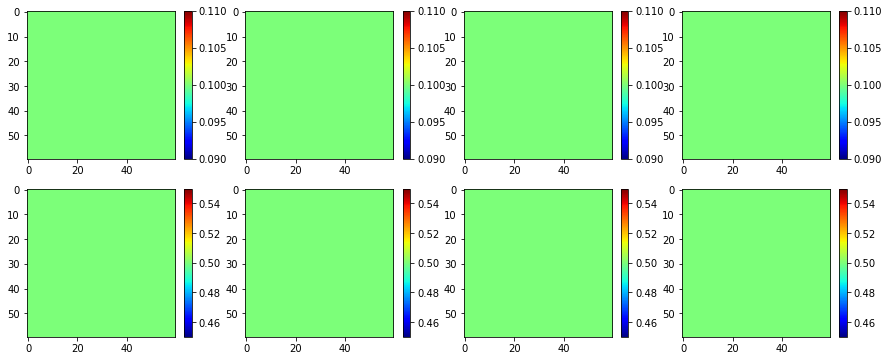

In [31]:
plt.figure(figsize=(15,6))
for k in range(num_case):
    plt.subplot(2,4,k+1)
    plt.imshow(sat_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,4,k+5)
    plt.imshow(pres_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
plt.show()

In [32]:
print(sat_t_seq.shape)
print(sat_pred.shape)
print(pres_t_seq.shape)
print(pres_pred.shape)
print(bhp_seq.shape)

(4, 60, 60, 1)
(4, 20, 60, 60, 1)
(4, 60, 60, 1)
(4, 20, 60, 60, 1)
(4, 9)


In [33]:
state_t_seq = np.concatenate((sat_t_seq, pres_t_seq),axis=3)
state_pred = np.concatenate((sat_pred, pres_pred),axis=4)
print(state_t_seq.shape)
print(state_pred.shape)

(4, 60, 60, 2)
(4, 20, 60, 60, 2)


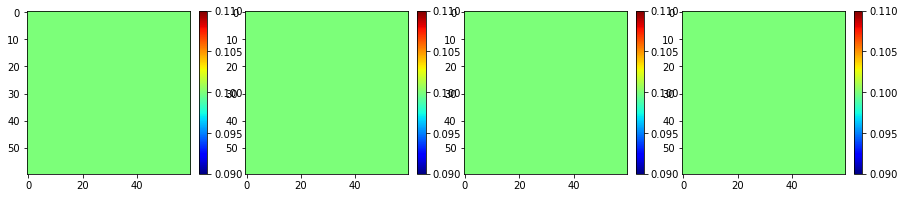

In [34]:
plt.figure(figsize=(15,3))
for k in range(num_case):
    plt.subplot(1,4,k+1)
    plt.imshow(state_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
plt.show()

In [35]:
# dt_seq = np.ones((num_case, 1))
print(bhp_seq.shape)

(4, 9)


In [36]:
for i_tstep in range(num_tstep):
    state_pred[:, i_tstep, ...] = state_t_seq.copy()
    dt_seq = np.ones((num_case,1)) * indt_del[i_tstep]
    [_, state_t1_seq] = e2c_model.predict([state_t_seq, bhp_seq, dt_seq])
    state_t_seq = state_t1_seq.copy()

In [37]:
# t_steps = list(np.arange(4,104,10))
t_steps = indt
print(t_steps)
# num_tstep = len(t_steps)

[ 0  1  3  7 15 25 26 28 32 40 50 51 53 57 65 75 76 78 82 90]


In [38]:
print(sat.shape)
print(pres.shape)
# print(state.shape)

(400, 101, 3600)
(400, 101, 3600)


In [39]:
sat_seq_true = sat[ind_case, ...]
sat_seq_true = sat_seq_true[:, t_steps, :]
print(sat_seq_true.shape)

pres_seq_true = pres[ind_case, ...]
pres_seq_true = pres_seq_true[:, t_steps, :]
print(pres_seq_true.shape)
state_seq_true = np.zeros((4,num_tstep,3600,2))
state_seq_true[:,:,:,0] = sat_seq_true
state_seq_true[:,:,:,1] = pres_seq_true
print(state_seq_true.shape)

(4, 20, 3600)
(4, 20, 3600)
(4, 20, 3600, 2)


Case num: 1


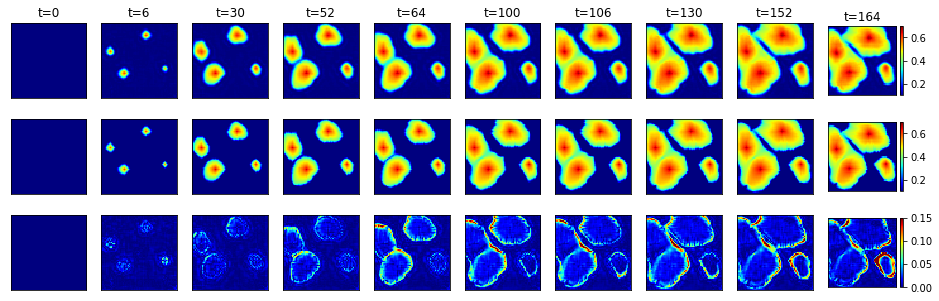

Case num: 101


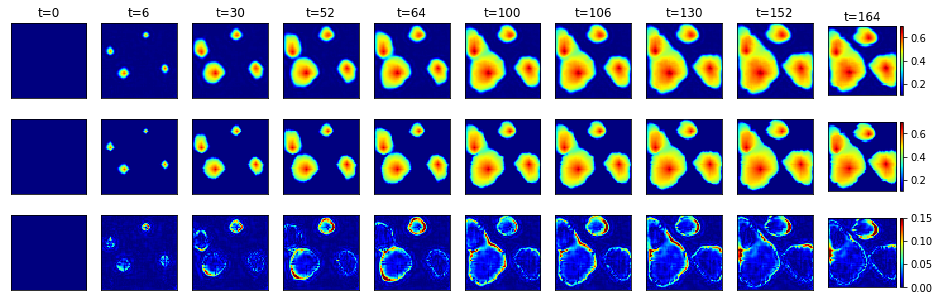

Case num: 201


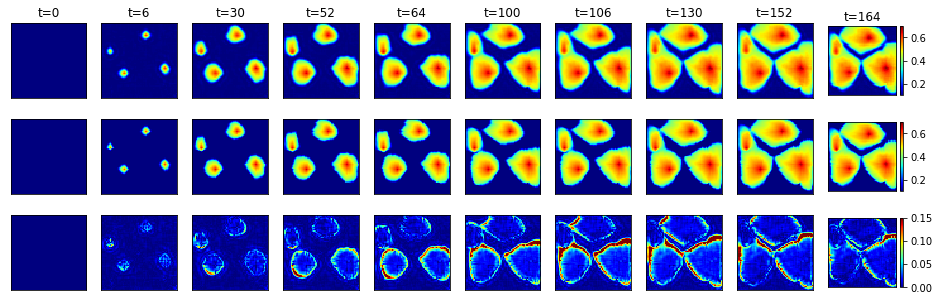

Case num: 301


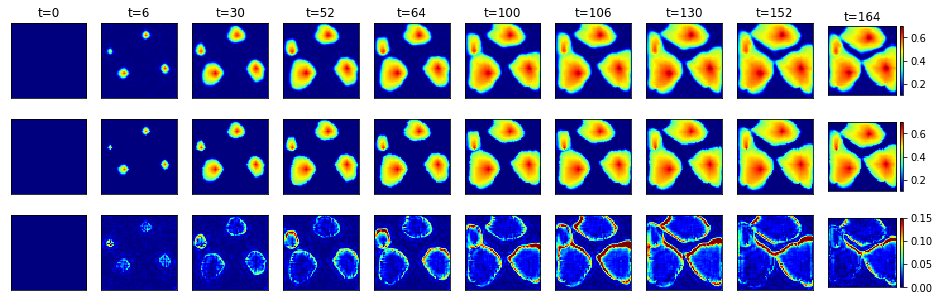

In [40]:
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//2):
        plt.subplot(3, num_tstep//2, i_tstep+1)
        plt.imshow(state_pred[k, i_tstep*2, :,:, 0])
        plt.title('t=%d'%(t_steps[i_tstep*2]*2))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//2, i_tstep+1+num_tstep//2)
        plt.imshow(state_seq_true[k, i_tstep*2, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//2, i_tstep+1+2*num_tstep//2)
        plt.imshow(np.fabs(state_seq_true[k, i_tstep*2, :, 0].reshape((60,60)) - state_pred[k, i_tstep*2, :,:, 0]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [41]:
state_pred_plot = state_pred[:, :, :, :, 1] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, :, :, 1] * p_diff + p_min

Case num: 1


Case num: 101


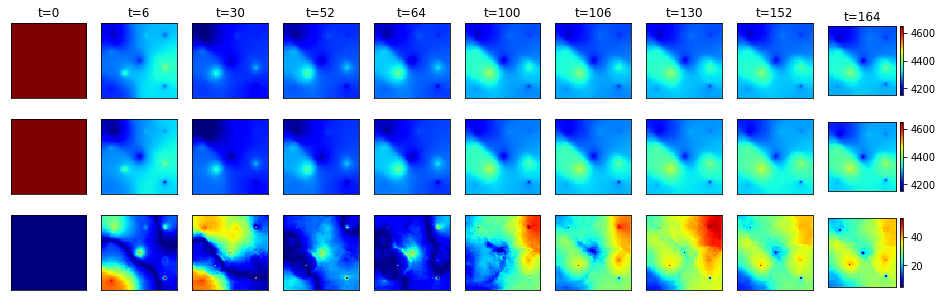

Case num: 201


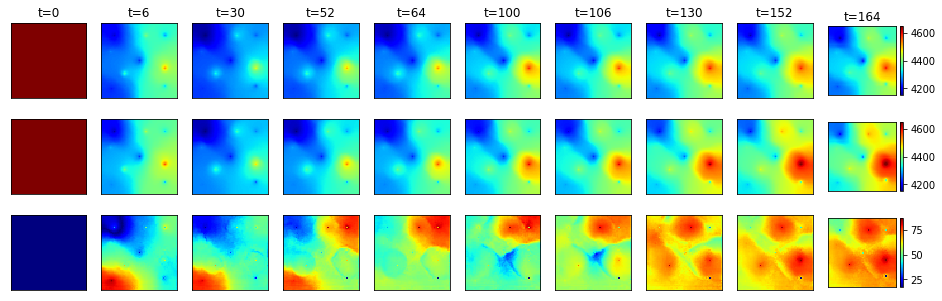

Case num: 301


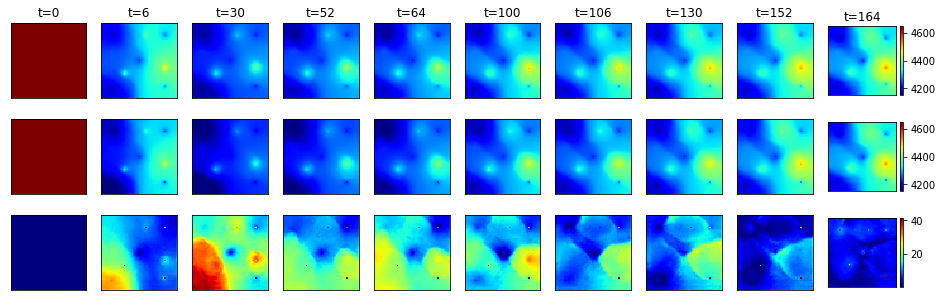

In [42]:
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//2):
        plt.subplot(3, num_tstep//2, i_tstep+1)
        plt.imshow(state_pred_plot[k, i_tstep*2, :, :])
        plt.title('t=%d'%(t_steps[i_tstep*2]*2))
        plt.xticks([])
        plt.yticks([])
        plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//2, i_tstep+1+num_tstep//2)
        plt.imshow(state_seq_true_plot[k, i_tstep*2, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//2, i_tstep+1+2*num_tstep//2)
        plt.imshow(np.fabs(state_seq_true_plot[k, i_tstep*2, :].reshape((60,60)) - state_pred_plot[k, i_tstep*2, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()